In [1]:
import pandas as pd
import numpy as np

In [2]:
X = pd.read_csv('../data/USA/LC/X_train.csv.gz')
y = pd.read_csv('../data/USA/LC/y_train.csv')
y = y.loan_status_bin  #as series

In [3]:
X['grade']=X['grade'].map({'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7})
X['annual_inc_log'] = X['annual_inc'].apply(np.log)
X.head()

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,...,delinq_2yrs,fico_range_low,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,hardship_flag,annual_inc_log
0,14400.0,60 months,12.49,323.90,2,7 years,MORTGAGE,40000.0,Not Verified,debt_consolidation,...,0.0,770.0,0.0,13.0,0.0,7771.0,13.8,30.0,N,10.596635
1,9600.0,36 months,13.99,328.06,3,6 years,RENT,60000.0,Verified,debt_consolidation,...,0.0,675.0,1.0,12.0,0.0,10965.0,87.7,31.0,N,11.002100
2,11500.0,60 months,15.61,277.29,3,10+ years,RENT,34000.0,Source Verified,debt_consolidation,...,0.0,685.0,0.0,7.0,0.0,9321.0,48.8,8.0,N,10.434116
3,10000.0,36 months,11.49,329.72,2,10+ years,MORTGAGE,49000.0,Source Verified,credit_card,...,1.0,680.0,1.0,9.0,0.0,5984.0,48.3,34.0,N,10.799576
4,3500.0,36 months,19.03,128.35,4,10+ years,MORTGAGE,40000.0,Source Verified,debt_consolidation,...,0.0,660.0,0.0,7.0,1.0,9254.0,54.1,16.0,N,10.596635


In [4]:
import joblib
pipe_lss = joblib.load('../data/USA/LC/state_lss.pkl')

In [5]:
df_state = pd.read_csv('../data/USA/State/state_data.csv')
df_state['state_var'] = pipe_lss.predict(df_state)
df_state.head(4)

,N,State_Name,Code,GDP_PC,gini,cost_living,hdi,pbf,ccdebt,spi,unemp,state_var
0,1,Alabama,AL,45219,0.4847,89.87,4.04,519,7105,33.60,3.9,0.069859
1,2,Alaska,AK,73205,0.4081,122.88,5.06,56,13048,43.77,6.5,-0.013420
2,3,Arizona,AZ,48055,0.4713,97.66,4.89,305,7100,45.43,4.7,-0.000735
3,4,Arkansas,AR,42454,0.4719,89.17,3.91,374,6747,32.10,3.6,0.081117


In [6]:
state_dict = {}
for s,x in zip(df_state.Code,df_state.state_var):
    state_dict[s] = x 

In [7]:
state_mcoefs = []
for s in X.addr_state:
    state_mcoefs.append(state_dict[s])
X['m_coefs'] = state_mcoefs 

In [8]:
pipe_fico = joblib.load('../data/USA/LC/fico_model.pkl')

In [9]:
X['fico_pred'] = pipe_fico.predict(X) 

In [10]:
pipe_grade = joblib.load('../data/USA/LC/grade_model.pkl')

In [11]:
X['grade_pred'] = pipe_grade.predict(X) 

In [53]:
used_vars = ['loan_amnt', 'term', 'int_rate',
       'installment', 'grade_pred', 'emp_length',
       'home_ownership', 'annual_inc_log', 'verification_status',
       'purpose', 'm_coefs', 'dti', 'delinq_2yrs',
       'fico_pred', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc']


used_vars = ['loan_amnt', 'term', 'int_rate',
       'installment',  'emp_length',
       'home_ownership', 'annual_inc_log', 'verification_status',
       'purpose', 'm_coefs', 'fico_pred', 'grade_pred', 'dti', 'delinq_2yrs',
        'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc']


In [54]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from transformers import ColumnSelectTransformer, EncoderTransformer

cst = ColumnSelectTransformer(used_vars)
sce = EncoderTransformer()
sc = MinMaxScaler()
clf = LogisticRegression(penalty='l1', C=0.01, random_state=0, solver='liblinear')

pipe_lr = Pipeline([('colsel', cst), ('encoder', sce), ('scaler', sc), ('clf', clf)])

In [55]:
pipe_lr.fit(X, y)

Pipeline(memory=None,
     steps=[('colsel', ColumnSelectTransformer(col_names=['loan_amnt', 'term', 'int_rate', 'installment', 'emp_length', 'home_ownership', 'annual_inc_log', 'verification_status', 'purpose', 'm_coefs', 'fico_pred', 'grade_pred', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', '...nalty='l1', random_state=0, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))])

In [56]:
X_t = pd.read_csv('../data/USA/LC/X_test.csv')
y_t = pd.read_csv('../data/USA/LC/y_test.csv')
y_t = y_t.loan_status_bin  #as series

In [57]:
X_t['grade']=X_t['grade'].map({'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7})
X_t['annual_inc_log'] = X_t['annual_inc'].apply(np.log)

In [58]:
tstate_mcoefs = []
for s in X_t.addr_state:
    tstate_mcoefs.append(state_dict[s])
X_t['m_coefs'] = tstate_mcoefs 

In [59]:
X_t['fico_pred'] = pipe_fico.predict(X_t) 

In [60]:
X_t['grade_pred'] = pipe_grade.predict(X_t) 

In [61]:
test_probas = pipe_lr.predict_proba(X_t)[:,1]

ROC-AUC-score:  0.7067196626703043


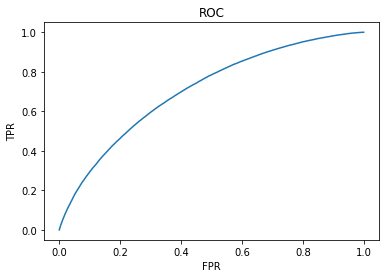

In [62]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, tresholds = roc_curve(y_t, test_probas)
plt.plot(fpr, tpr)
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')

print('ROC-AUC-score: ', roc_auc_score(y_t, test_probas))

0.7129 original (fico + state + grade) <br>
0.708 fico_p + state_p + grade  <br>
0.70672 fico_p + state_p + grade_p  <br>
0.7067 fico_p + state_p - grade  <br>
0.7062 - fico - state - grade <br>

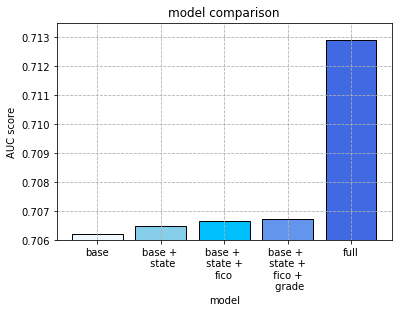

In [91]:
import matplotlib.pyplot as plt   
  
# x-coordinates of left sides of bars   
left = [1, 2, 3, 4, 5]   
  
# heights of bars   
height = [0.7062, 0.7065, 0.706657, 0.70672, 0.7129]   
  
# labels for bars   
tick_label = ['base', 'base + \n state', 'base + \n state + \nfico', 'base + \n state + \n fico + \n grade', 'full']   
  
plt.grid(True, linestyle='dashed',zorder=0)
# plotting a bar chart   
plt.bar(left, height, tick_label = tick_label,   
        width = 0.8, color = ['aliceblue', 'skyblue','deepskyblue', 'cornflowerblue', 'royalblue'], edgecolor = 'black') 

plt.ylim(0.7060, 0.7135)

  
# naming the x-axis   
plt.xlabel('model')   
# naming the y-axis   
plt.ylabel('AUC score')   
# plot title   
plt.title('model comparison')   
  
# function to show the plot  

plt.show()   